## A Tutorial on Signature Verification with the Signver Library

In [69]:
from signver.detector import Detector
from signver.cleaner import Cleaner
from signver.extractor import MetricExtractor
from signver.matcher import Matcher
from signver.utils import data_utils, visualization_utils
from signver.utils.data_utils import invert_img, resnet_preprocess
from signver.utils.visualization_utils import plot_np_array, visualize_boxes, get_image_crops, make_square

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

## Instantiate the Detector, Extractor and Cleaner Modules

In [70]:
detector_model_path = "models/detector/small"
detector = Detector()
detector.load(detector_model_path)

In [71]:
extractor_model_path = "models/extractor/metric"
extractor = MetricExtractor() 
extractor.load(extractor_model_path)

In [72]:
cleaner_model_path = "models/cleaner/small"
cleaner = Cleaner() 
cleaner.load(cleaner_model_path)

## Download a Test Signature Image

In [84]:
file_url = "https://magazine.art21.org/wp-content/uploads/2009/06/signed-document-by-nam-june-paik-from-the-imas-historical-files.jpg"
file_url_2="https://swimmingfreestyle.net/wp-content/uploads/2019/10/contract-signature-page-example-new-elgin-munity-college-faculty-association-eccfa-of-contract-signature-page-example.png"
file_name = "signdoc.jpg" 
destination_dir = "data/test/localizer"
img_path = data_utils.download_file(file_url_2, file_name,  destination_dir) 

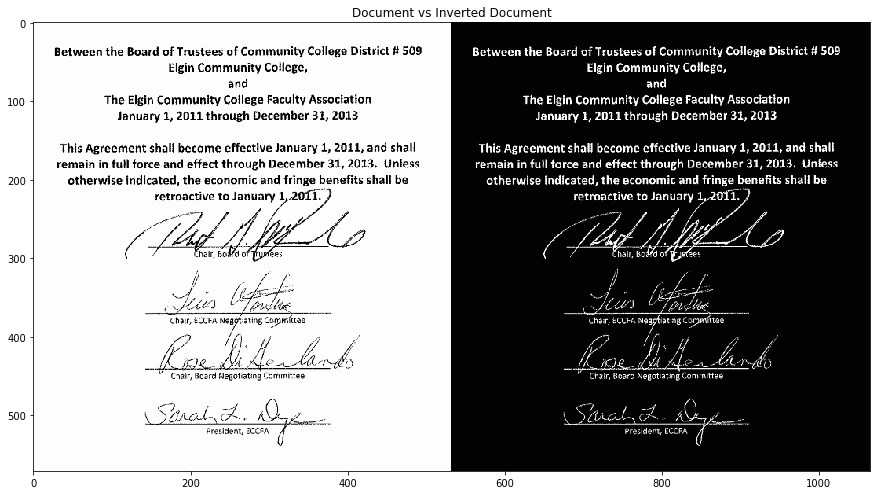

In [85]:
image_np = data_utils.img_to_np_array(img_path)
inverted_image_np = data_utils.img_to_np_array(img_path, invert_image=True)

img_tensor = tf.convert_to_tensor(inverted_image_np)
img_tensor = img_tensor[tf.newaxis, ...]

plot_np_array( np.concatenate((image_np, inverted_image_np ), axis = 1), title="Document vs Inverted Document")

## Get Localization Predictions (Where are Signatures in the Image?)

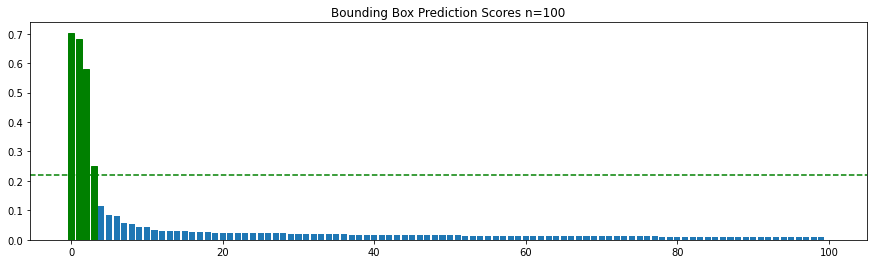

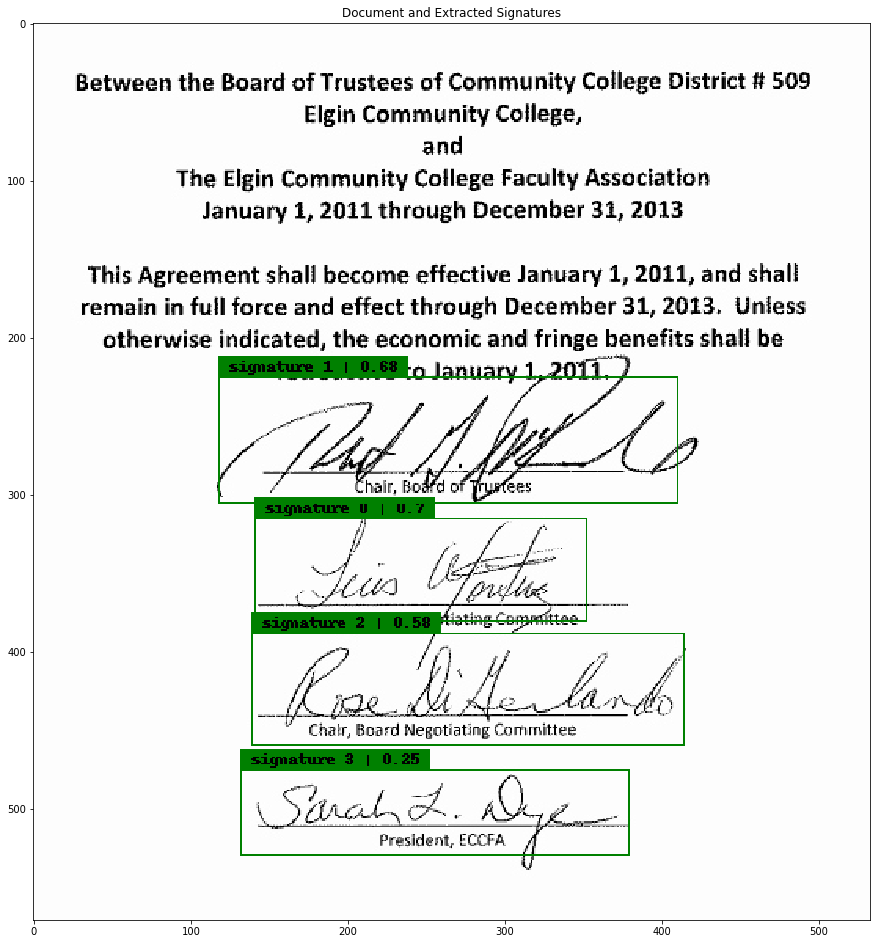

In [86]:
# get a list of bounding box predictions for image
boxes, scores, classes, detections = detector.detect(img_tensor)

# plot confidence scores for each detections
threshold = 0.22
plt.figure(figsize=(15,4))
barlist = plt.bar(range(len(scores)),scores);
[ x.set_color('g') for x in barlist if x.get_height() > threshold]
plt.axline((0, threshold), (100, threshold), color="g", linestyle="--");
plt.title("Bounding Box Prediction Scores n=" + str(len(scores)));

# annotate image with bounding boxes above a given threshold and plot 
annotated_image = visualize_boxes(image_np, boxes, scores, threshold=threshold, color="green")
plot_np_array(annotated_image, title="Document and Extracted Signatures")  

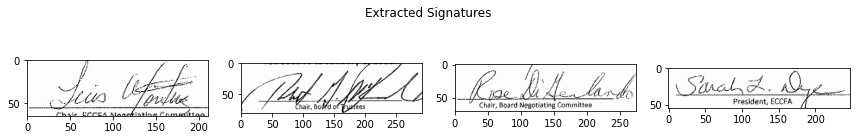

In [87]:
signatures = get_image_crops(image_np, boxes, scores,  threshold = 0.22 )
plot_np_array(signatures, fig_size=(12,14), ncols=4, title="Extracted Signatures")

## Extract Features from Signatures

/Users/victordibia/projects/personal/signver/signver/utils/data_utils.py:19: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.
  thresh = threshold_otsu(img_arr)


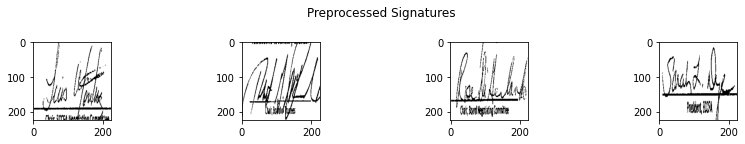

In [88]:
sigs= [ resnet_preprocess( x, resnet=False, invert_input=False ) for x in signatures ]
plot_np_array(sigs,"Preprocessed Signatures") 


In [89]:
test_line = data_utils.img_to_np_array("data/test/extractor/test_lines.png")
test_line = resnet_preprocess( test_line, resnet=False , invert_input=False)  

cn = cleaner.clean(np.expand_dims(test_line, axis=0))


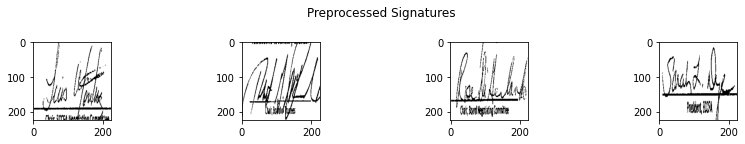

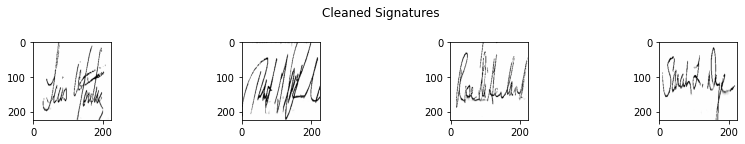

In [90]:
norm_sigs = [ x * (1./255) for x in sigs]
plot_np_array(norm_sigs,"Preprocessed Signatures")
cleaned_sigs = cleaner.clean(np.array(norm_sigs))
# cleaned_sigs = cleaner.clean(cleaned_sigs)
# cleaned_sigs = cleaner.clean(cleaned_sigs)
plot_np_array(list(cleaned_sigs),"Cleaned Signatures")

# 

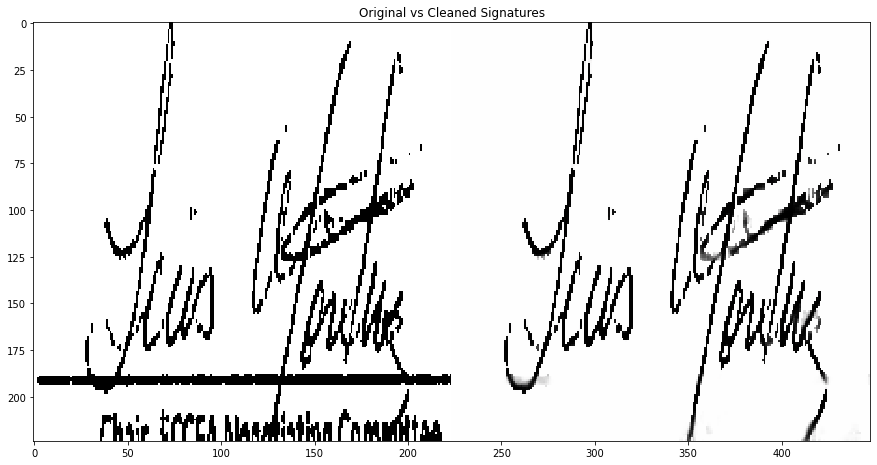

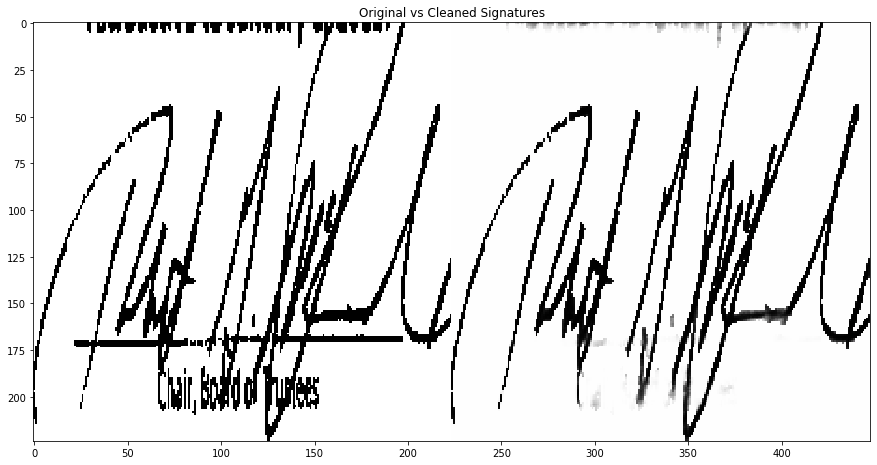

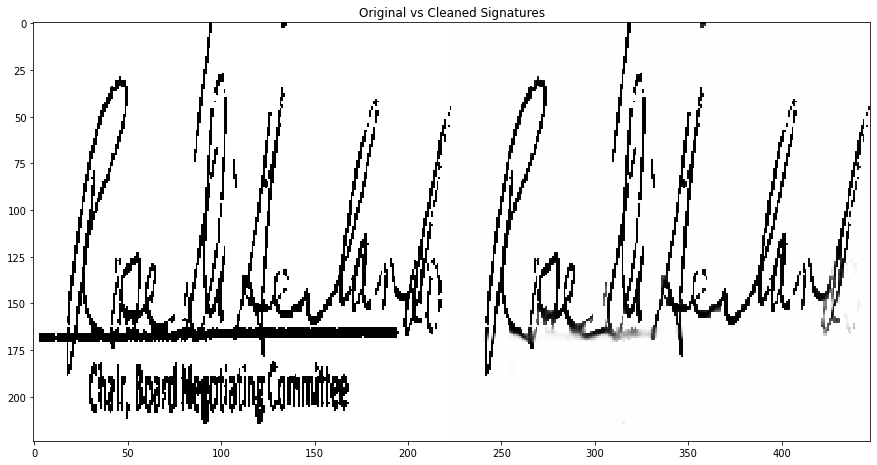

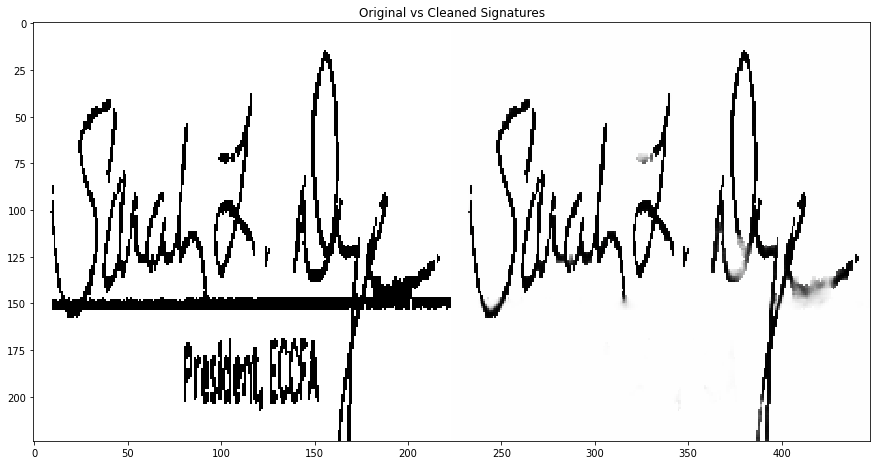

In [91]:
for i in range(len(cleaned_sigs)):
    plot_np_array(np.concatenate((norm_sigs[i], cleaned_sigs[i]) , axis=1), title="Original vs Cleaned Signatures")
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


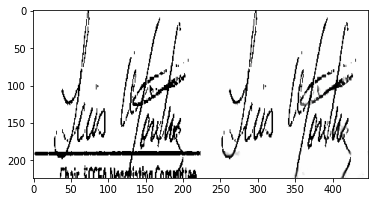

In [92]:
plt.imshow(np.concatenate((sigs[0], cleaned_sigs[0]) , axis=1))

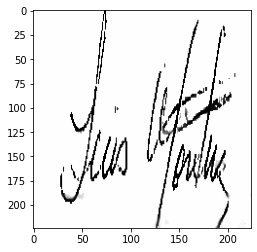

In [93]:
plt.imshow(cleaned_sigs[0])
# cleaned_sigs[0]


In [94]:
feats = extractor.extract(np.array(sigs) / 255)
feat1,feat2,feat3  = feats[0,:], feats[1,:], feats[2,:]  

cleaned_feats = extractor.extract(cleaned_sigs ) 
c_feat1,c_feat2,c_feat3 = cleaned_feats[0,:], cleaned_feats[1,:], cleaned_feats[2,:]  

## Verify Signatures 

## Distance Before Cleaning

In [95]:
matcher = Matcher()
print( "Distance between Signature 1 and 1 -> ", matcher.cosine_distance(feat1,feat1) )
print( "Distance between Signature 1 and 2 -> ", matcher.cosine_distance(feat1,feat2) )
print( "Distance between Signature 1 and 3 -> ", matcher.cosine_distance(feat1,feat3) )
print( "Distance between Signature 2 and 3 -> ", matcher.cosine_distance(feat2,feat3) )

print( "Is Signature 1 and 1 from same user ? -> ", matcher.verify(feat1,feat1) )
print( "Is Signature 1 and 2 from same user ? -> ", matcher.verify(feat1,feat2) )
print( "Is Signature 1 and 3 from same user ? -> ", matcher.verify(feat1,feat3) )
print( "Is Signature 2 and 3 from same user ? -> ", matcher.verify(feat2,feat3) )


Distance between Signature 1 and 1 ->  0
Distance between Signature 1 and 2 ->  0.4119170904159546
Distance between Signature 1 and 3 ->  0.3194839358329773
Distance between Signature 2 and 3 ->  0.26877427101135254
Is Signature 1 and 1 from same user ? ->  True
Is Signature 1 and 2 from same user ? ->  False
Is Signature 1 and 3 from same user ? ->  False
Is Signature 2 and 3 from same user ? ->  False


## Distance After Cleaning

In [ ]:
matcher = Matcher()
print( "Distance between Signature 1 and 1 -> ", matcher.cosine_distance(c_feat1,c_feat1) ) 
print( "Distance between Signature 1 and 2 -> ", matcher.cosine_distance(c_feat1,c_feat2) )
print( "Distance between Signature 1 and 3 -> ", matcher.cosine_distance(c_feat1,c_feat3) )
print( "Distance between Signature 2 and 3 -> ", matcher.cosine_distance(c_feat2,c_feat3) ) 
